In [58]:
%pylab inline
import gc
import matplotlib
import scipy
import fitsio
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
cmap=plt.get_cmap('tab20')

import hmf
import simutil
import haloSim
from cosmology import Cosmo
cosmo   =   Cosmo(h=1.,omega_m=0.315)

from configparser import ConfigParser
from pixel3D import cartesianGrid3D

figMsDir='/home/xiangchong/Documents/Docs/massMap/2-cluster_HSC_2021/'



Populating the interactive namespace from numpy and matplotlib


In [2]:
# h in Cosmo should be fixed to 1 (geometry fixed)
if False:
    cosmo   =   Cosmo(h=0.674,omega_m=0.315)
    v1=cosmo.V(zmin[iz],zmax[iz])
    rho1=cosmo.rho0()
    cosmo   =   Cosmo(h=1.,omega_m=0.315)
    v2=cosmo.V(zmin[iz],zmax[iz])
    rho2=cosmo.rho0()
    print(v1/v2*0.674**3.)
    print(rho1/rho2/0.674**2.)
# simply changing h change the hmf?
if False:
    mf = hmf.MassFunction(Mmin=14.,Mmax=14.1,dlog10m=0.05,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
    mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
    n1=mf.dndm
    mf = hmf.MassFunction(Mmin=14.,Mmax=14.1,dlog10m=0.05,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
    mf.update(cosmo_params={"Om0":0.315,"H0":100})
    n2=mf.dndm

In [3]:
configName  =   'wrkDir/config-nl10.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)
print(gridInfo.zlcgrid)
lensKer0=gridInfo.lensing_kernel(deltaIn=False)
lensKer1=gridInfo.lensing_kernel(deltaIn=True)
zbound=gridInfo.zlbound
zave=gridInfo.zlcgrid



[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [19]:
# Initialize hmf
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=14.,Mmax=14.6,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)
#Prepare basis vectors
outDir='wrkDir/prior/'
ngrid=64
nn=500

if True:
    haloAveAll=np.empty((gridInfo.nzl,1,ngrid,ngrid))
    for iz in range(0,gridInfo.nzl):
        z=zave[iz]
        pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi #[Mpc/h]
        mf.update(z=z)
        m = mf.m
        v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
        mass_func = mf.dndm*v
        imgList=np.empty((nn,ngrid,ngrid))
        rsAve=0.
        for i in range(nn):
            mi=simutil.mcSample(m,mass_func)
            conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
            rs_arcmin=haloSim.mc2rs(mi,conc,z)
            rsAve+=rs_arcmin
            imgList[i]=haloSim.haloCS02SigmaAtom(rs_arcmin,ngrid,ngrid,c=conc,smooth_scale=1.5,fou=False,lnorm=1)*mi/pix2mpc**2.

        print(rsAve/nn)
        print(pix2mpc**2.)
        selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
        haloAve=np.average(imgList,axis=0)
        #norm=np.sqrt(np.sum(haloAve**2.))
        norm=np.sum(haloAve)*pix2mpc**2.
        # normalize to make sure \int dxdy f(x,y)=1
        haloAve=haloAve/norm
        haloAveAll[iz,0]=haloAve
        del imgList,haloAve
        gc.collect()
    mask=haloAveAll>1e-5
    haloAveAll[~mask]=0.
    print(np.min(haloAveAll))
    pyfits.writeto(os.path.join(outDir,'haloBasis-nl10.fits'),haloAveAll,overwrite=True)

[2.3270984]
0.0059867100898951045
[1.26860653]
0.019121320460355303
[0.92887002]
0.03477238117103408
[0.73713277]
0.05049411021997751
[0.62203816]
0.06505434642878558
[0.55464469]
0.07790092332332635
[0.49893396]
0.08885976434155021
[0.45541604]
0.09796103750388584
[0.42501432]
0.10533845013156251
[0.39423894]
0.11117124109660739
0.0


0.6309573444800652
[-1.67805702 -1.19640294  0.57284285]
0.6309573444800652
[-2.26748867 -0.3581646   0.9432847 ]
0.6309573444800652
[-2.67154334 -0.17351286  1.24493054]
0.6309573444800652
[-2.80223271 -0.2855793   1.14435529]
0.6309573444800652
[-2.79042122 -0.59611515  0.97032405]


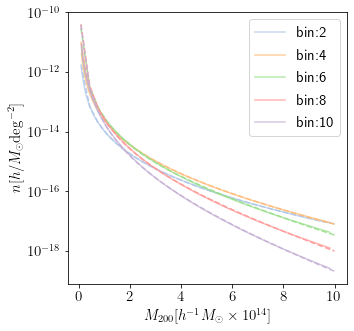

In [82]:
def fit_func(x,a,b,c):
    return -31+a*np.log(x)+b*x**c
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=13.0,Mmax=15.,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
# Prepare Prior
plt.close()
ngrid=64
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(1,1,1)

for iz in range(1,10,2):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    mf.update(z=z)
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m/1e14
    print(m[100])
    sAll=np.sum(mass_func)
    ax1.plot(m,mass_func,label='bin:%d' %(iz+1),color=cmap(iz),alpha=0.7)
    out=scipy.optimize.curve_fit(fit_func,m[100:],np.log(mass_func[100:]))[0]
    print(out)
    x=np.linspace(0.08,10.,30)
    ax1.plot(x,np.exp(fit_func(x,*out)),ls='--',color=cmap(iz),alpha=0.9)
    
ax1.set_xlabel(r'$M_{200} [h^{-1}M_{\odot}\times 10^{14}]$')
ax1.set_ylabel(r'$n[h/M_{\odot}\rm{deg}^{-2}] $')
ax1.set_yscale('log')
ax1.legend()

[-29.79700703  -3.62604635]
[-27.82284778  -3.94797693]
[-26.98499468  -4.33628937]
[-26.50548843  -4.7914756 ]
[-26.20403455  -5.31325648]


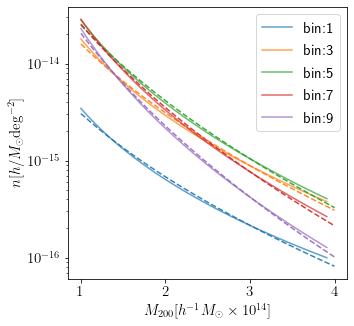

In [91]:
def fit_func(x,a,b):
    return a+b*x**0.5
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=14.,Mmax=14.6,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
# Prepare Prior
plt.close()
ngrid=64
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(1,1,1)

for iz in range(0,10,2):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    mf.update(z=z)
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m/1e14
    sAll=np.sum(mass_func)
    ax1.plot(m,mass_func,label='bin:%d' %(iz+1),color=cmap(iz),alpha=0.7)
    out=scipy.optimize.curve_fit(fit_func,m,np.log(mass_func))[0]
    print(out)
    x=np.linspace(1.,4.,30)
    ax1.plot(x,np.exp(fit_func(x,*out)),ls='--',color=cmap(iz),alpha=0.9)
    
ax1.set_xlabel(r'$M_{200} [h^{-1}M_{\odot}\times 10^{14}]$')
ax1.set_ylabel(r'$n[h/M_{\odot}\rm{deg}^{-2}] $')
ax1.set_yscale('log')
ax1.legend()

7144
18440
32846
48716
64714
79804
93231
104490


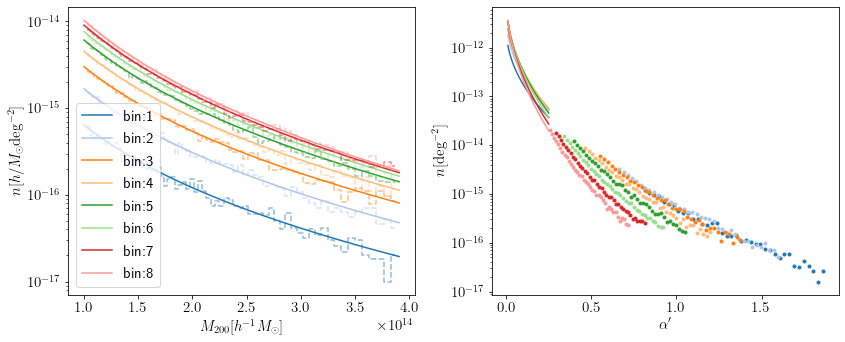

In [44]:
# Prepare Prior
haloAveAll=pyfits.getdata(os.path.join(outDir,'haloBasis-nl10.fits'))[:,0,:,:]

plt.close()
nscale=5e17
ngrid=64
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
parAll=[]

for iz in range(0,8):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    mf.update(z=z)
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    sAll=np.sum(mass_func)
    msample=[]
    nn=int(sAll*nscale)
    print(nn)
    imgList=np.empty((nn,ngrid,ngrid))
    for i in range(nn):
        mi=simutil.mcSample(m,mass_func)
        msample.append(mi)
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        imgList[i]=haloSim.haloCS02SigmaAtom(rs_arcmin,ngrid,ngrid,c=conc,smooth_scale=1.5,fou=False,lnorm=1)*mi/pix2mpc**2.
    msample=np.array(msample)
    y=np.histogram(msample,bins=m)[0]
    ax1.plot(m,mass_func,label='bin:%d' %(iz+1),color=cmap(iz))
    ax1.step((mf.m[2:]+mf.m[1:-1])/2.,y[1:]/nscale,where='mid',color=cmap(iz),ls='--',alpha=0.5)
    
    haloAve=haloAveAll[iz]
    proj1=np.sum(imgList*haloAve[None,:,:],axis=(1,2))
    hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*proj1,bins=40)
    bave=(bounds[1:]+bounds[:-1])/2.
    ax2.scatter(bave[2:],hist[2:]/nscale,marker='.',color=cmap(iz))
    out=scipy.optimize.curve_fit(fit_func,bave[2:],np.log(hist[2:]/nscale))[0]
    x=np.linspace(0.01,0.25,30)
    ax2.plot(x,np.exp(fit_func(x,*out)),color=cmap(iz))
    parAll.append(out)
    del msample,imgList,hist,bounds
    gc.collect()
    
    
ax1.set_xlabel(r'$M_{200} [h^{-1}M_{\odot}]$')
ax1.set_ylabel(r'$n[h/M_{\odot}\rm{deg}^{-2}]$')
ax1.set_yscale('log')
ax1.legend()
ax2.set_xlabel(r"$\alpha'$")
ax2.set_ylabel(r'$n[\rm{deg}^{-2}]$')
ax2.set_yscale('log')
plt.tight_layout()

prior=np.array([tuple(a) for a in parAll],dtype=[('a00','>f4'),('a05','>f4')])
fitsio.write(os.path.join(outDir,'prior.fits'),prior)

In [50]:
# Prepare Prior
haloAveAll=pyfits.getdata(os.path.join(outDir,'haloBasis.fits'))

plt.close()
ngrid=64

mi=1e14
for iz in range(0,8):
    z=zave[iz]
    rhoM_ave=gridInfo.cosmo.rho_m(z)
    DaBin=gridInfo.cosmo.Da(gridInfo.zlbound[iz],gridInfo.zlbound[iz+1])
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
    
    rs_arcmin=haloSim.mc2rs(mi,conc,z)
    img=haloSim.haloCS02SigmaAtom(rs_arcmin,ngrid,ngrid,c=conc,smooth_scale=1.5,fou=False,lnorm=1)*mi/pix2mpc**2./rhoM_ave/DaBin
    haloAve=haloAveAll[iz,0]
    proj1=np.sum(img*haloAve)
    proj2=np.sqrt(np.sum(img**2.))
    #print(proj1)
    #print(np.sqrt(np.sum(lensKer1.T[iz,:]**2.)))
    print(proj1*np.sqrt(np.sum(lensKer1.T[iz,:]**2.)))
    print(img[0,0]*lensKer1.T[iz,:])

0.7418745777182436
[0.03645566 0.04449954 0.04601123 0.04710886 0.0479311  0.04847842
 0.04891517 0.04935951 0.04983585 0.05055599]
0.6014650853036999
[0.02590357 0.04028367 0.04298613 0.04494836 0.04641829 0.04739674
 0.04817753 0.04897187 0.04982343 0.05111082]
0.49608626056567684
[0.01370607 0.03376803 0.03753828 0.04027583 0.04232657 0.04369161
 0.04478091 0.04588911 0.04707714 0.0488732 ]
0.4154398147207186
[0.00189326 0.02703568 0.0317607  0.03519151 0.03776157 0.03947229
 0.04083744 0.04222628 0.04371517 0.04596605]
0.3524628530148654
[0.         0.02059828 0.02617943 0.03023187 0.03326759 0.03528829
 0.03690078 0.03854127 0.04029993 0.04295864]
0.30100714549915725
[0.         0.01459446 0.02094594 0.0255577  0.02901242 0.03131202
 0.03314708 0.03501399 0.03701538 0.04004105]
0.25864071763424373
[0.         0.00905029 0.01609925 0.02121745 0.02505155 0.02760368
 0.02964025 0.03171217 0.03393335 0.03729128]
0.22364705532726417
[0.         0.00394605 0.01163234 0.0172133  0.021394

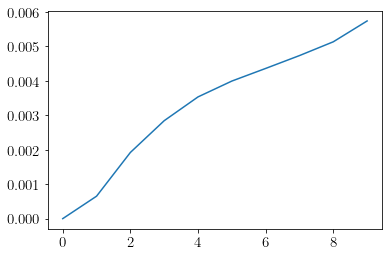

In [25]:
plt.plot(lensKer1.T[7])

In [32]:
lensKer1[:,7]

array([0.        , 0.00065114, 0.00191944, 0.00284035, 0.00353022,
       0.00398941, 0.00435585, 0.00472865, 0.0051283 , 0.00573249])

In [33]:
gridInfo.zlcgrid

array([0.0625, 0.1075, 0.1525, 0.1975, 0.2425, 0.2875, 0.3325, 0.3775])

7144
32846
64714
93231


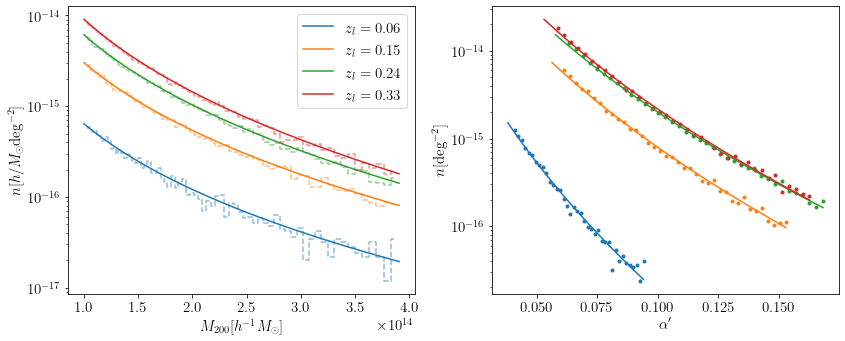

In [26]:
# Prepare Prior
haloAveAll=pyfits.getdata(os.path.join(outDir,'haloBasis.fits'))
prior=pyfits.getdata(os.path.join(outDir,'prior.fits'))

plt.close()
nscale=5e17
ngrid=64
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
parAll=[]

for iz in range(0,8,2):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi
    mf.update(z=z)
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    m = mf.m
    sAll=np.sum(mass_func)
    msample=[]
    nn=int(sAll*nscale)
    print(nn)
    imgList=np.empty((nn,ngrid,ngrid))
    for i in range(nn):
        mi=simutil.mcSample(m,mass_func)
        msample.append(mi)
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        imgList[i]=haloSim.haloCS02SigmaAtom(rs_arcmin,ngrid,ngrid,c=conc,smooth_scale=1.5,fou=False,lnorm=1)*mi/pix2mpc**2.
    msample=np.array(msample)
    y=np.histogram(msample,bins=m)[0]
    ax1.plot(m,mass_func,label=r'$z_l=%.2f$' %(z),color=cmap(iz))
    ax1.step((mf.m[2:]+mf.m[1:-1])/2.,y[1:]/nscale,where='mid',color=cmap(iz),ls='--',alpha=0.5)
    ax1.grid()
    
    haloAve=haloAveAll[iz]
    proj1=np.sum(imgList*haloAve[None,:,:],axis=(1,2))
    hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*proj1,bins=40)
    bave=(bounds[1:]+bounds[:-1])/2.
    ax2.scatter(bave[2:],hist[2:]/nscale,marker='.')
    out=prior[iz]
    ax2.plot(bave,np.exp(fit_func(bave,*out)))
    ax2.grid()
    del msample,imgList,hist,bounds
    gc.collect()
    
    
ax1.set_xlabel(r'$M_{200} [h^{-1}M_{\odot}]$')
ax1.set_ylabel(r'$n[h/M_{\odot}\rm{deg}^{-2}]$')
ax1.set_yscale('log')
ax1.legend()
ax2.set_xlabel(r"$\alpha'$")
ax2.set_ylabel(r'$n[\rm{deg}^{-2}]$')
ax2.set_yscale('log')
plt.tight_layout()

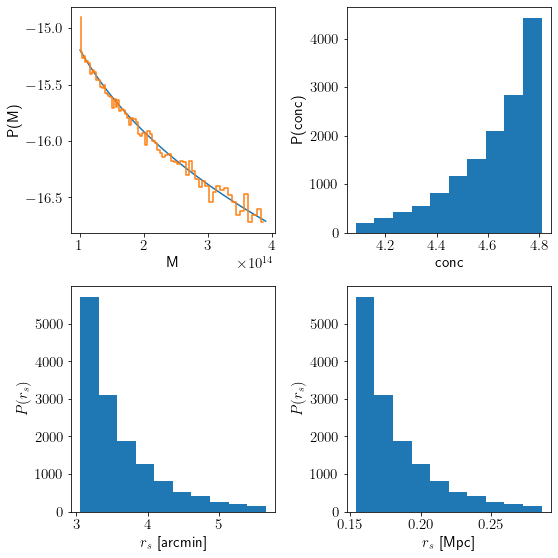

In [7]:
# One example redshift plane
iz=0
nscale=1e18
z=zave[iz]
mf.update(z=z)
v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
mass_func = mf.dndm*v
m = mf.m
msample=[]
sAll=np.sum(mass_func)
for i in range(int(sAll*nscale)):
    msample.append(simutil.mcSample(m,mass_func))
msample=np.array(msample)
conc =  6.02*(msample/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
rs_arcmin=haloSim.mc2rs(msample,conc,z)

# Plot
plt.close()
fig=plt.figure(figsize=(8,8))

ax=fig.add_subplot(2,2,1)
y=np.histogram(msample,bins=m)[0]
ax.plot(m,np.log10(mass_func/np.sum(mass_func)*sAll),label='bin:%d' %iz)
ax.step((mf.m[1:]+mf.m[:-1])/2.,np.log10(y/np.sum(y)*sAll),where='mid')
ax.set_xlabel('M')
ax.set_ylabel('P(M)')

ax=fig.add_subplot(2,2,2)
y=np.histogram(msample,bins=m)[0]
ax.hist(conc)
ax.set_xlabel('conc')
ax.set_ylabel('P(conc)')

ax=fig.add_subplot(2,2,3)
ax.hist(rs_arcmin)
ax.set_xlabel('$r_s$ [arcmin]')
ax.set_ylabel('$P(r_s)$')

ax=fig.add_subplot(2,2,4)
DaLens  =   cosmo.Da(0.,z) # angular distance in Mpc/h
arcmin2rad  =   np.pi/180./60.
rs       =   rs_arcmin*arcmin2rad* DaLens
ax.hist(rs)
ax.set_xlabel(r'$r_s$ [Mpc]')
ax.set_ylabel(r'$P(r_s)$')
plt.tight_layout()

907191053410107.2 118567920932576.69


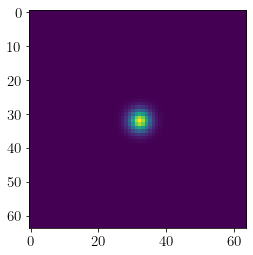

In [15]:
nn=5000
ngrid=64
imgList=np.empty((nn,ngrid,ngrid))
pix2mpc=cosmo.Da(0.,zave[iz])*1./60./180*np.pi
for i in range(nn):
    haloImg=haloSim.haloCS02SigmaAtom(rs_arcmin[i],ngrid,ngrid,c=conc[i],smooth_scale=1.5,fou=False,lnorm=1)*msample[i]/pix2mpc
    imgList[i]=haloImg
haloAve=np.average(imgList,axis=0)
imshow(np.fft.fftshift(haloAve))
print(np.sum(haloAve),np.sqrt(np.sum(haloAve**2.)))
norm=np.sqrt(np.sum(haloAve**2.))
haloAve=haloAve/norm

<ipython-input-16-ba755020d778>:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(bave[2:],np.log(hist[2:]),marker='.')


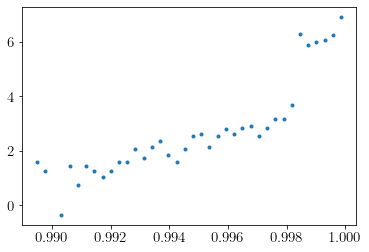

In [16]:
selfnorm1=np.sum(imgList,axis=(1,2))
selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
proj0=np.sum(imgList*haloAve[None,:,:],axis=(1,2))/selfnorm2
proj1=np.sum(imgList*haloAve[None,:,:],axis=(1,2))
hist,bounds=np.histogram(proj0,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

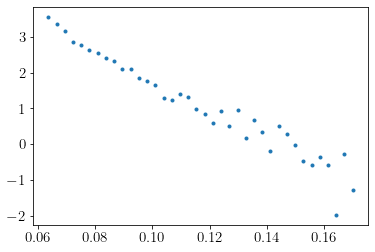

In [17]:
hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*selfnorm2,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

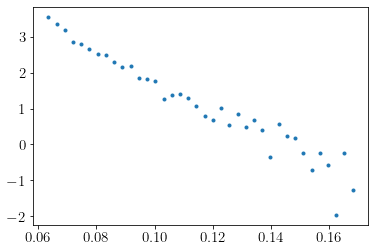

In [18]:
hist,bounds=np.histogram(np.sqrt(np.sum((lensKer0.T[iz])**2.))*proj1,bins=40,density=True)
bave=(bounds[1:]+bounds[:-1])/2.
plt.scatter(bave[2:],np.log(hist[2:]),marker='.')

In [35]:
pixG1=pyfits.getdata('wrkDir/test/g1Map-dempz.fits')
pixG2=pyfits.getdata('wrkDir/test/g2Map-dempz.fits')
pixStd=pyfits.getdata('wrkDir/test/stdMap-dempz.fits')

In [40]:
print(np.std(pixG1[pixStd>0.])*np.sqrt(2.))
print(np.average(pixStd[pixStd>0.]))

0.052384967669614015
0.04995704407369414
